In [14]:
import polars as pl
import matplotlib.pyplot as plt
import os
import numpy as np

In [15]:
def moving_average(x, window=20):
    """
    Compute a moving average with given window.

    Uses 'same' convolution so edges are smoothed with smaller effective window.
    """
    w = np.ones(window, dtype=float) / window
    return np.convolve(x, w, mode='same')

def plot_rewards_from_csv(file_path, window=20):
    # Load rewards data from CSV file using polars
    df = pl.read_csv(file_path)
    
    episodes = df['episode'].to_numpy()
    rewards = df['reward'].to_numpy()
    
    # Compute moving average
    rewards_ma = moving_average(rewards, window=window)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(episodes, rewards, label='Rewards', alpha=0.3)
    plt.plot(episodes, rewards_ma, label=f'Moving Average (window={window})', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Episode Rewards with Moving Average')
    plt.legend()
    plt.grid()
    plt.show()

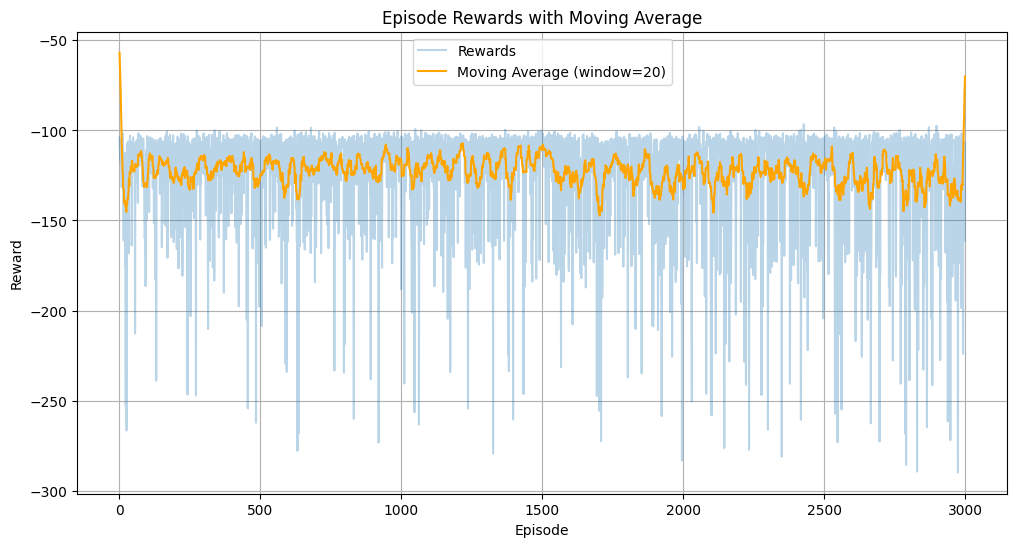

In [16]:
curr_dir = os.path.dirname(os.path.abspath(os.curdir))
file_path = os.path.join(curr_dir, "results", "a2c_single_env.csv")
plot_rewards_from_csv(file_path, window=20)

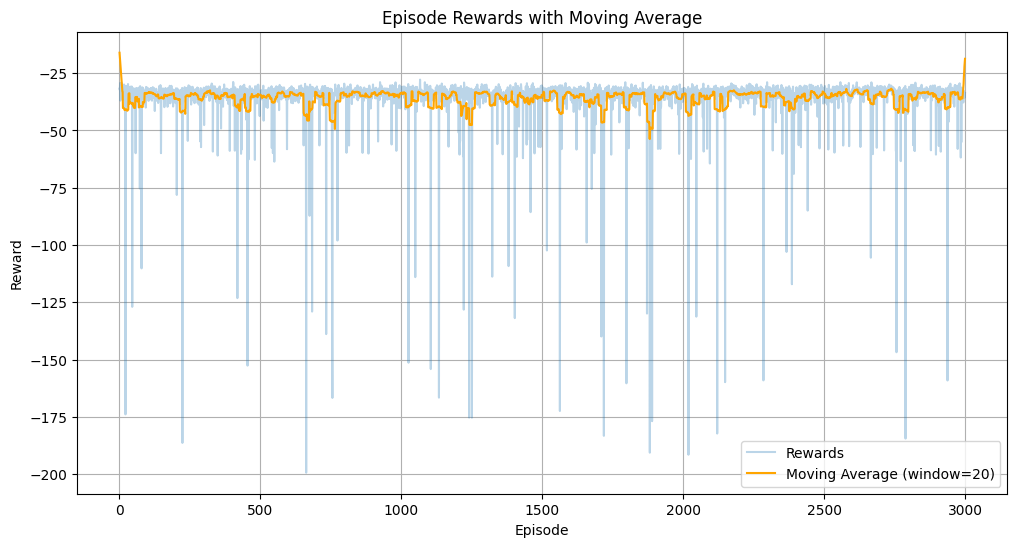

In [17]:
curr_dir = os.path.dirname(os.path.abspath(os.curdir))
file_path = os.path.join(curr_dir, "results", "a2c_four_envs.csv")
plot_rewards_from_csv(file_path, window=20)

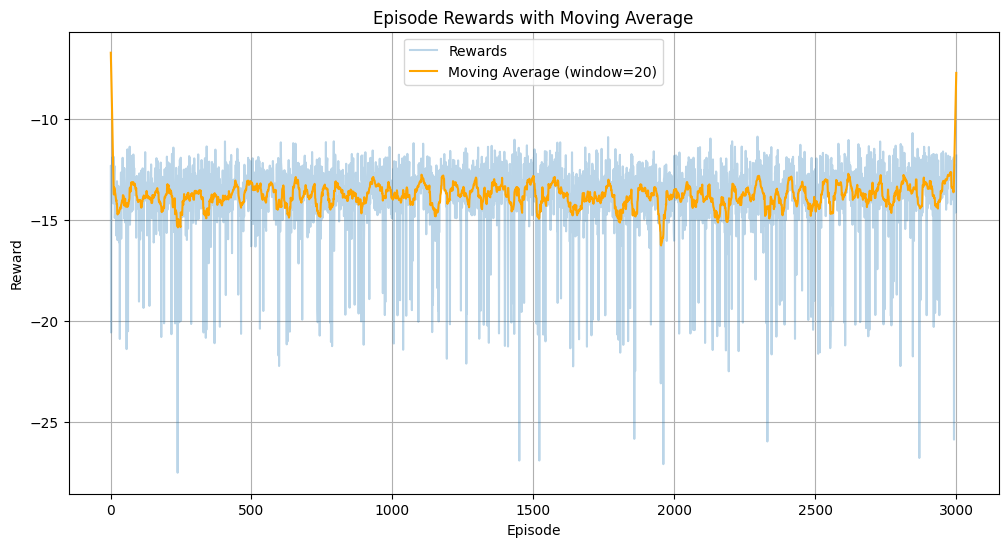

In [18]:
curr_dir = os.path.dirname(os.path.abspath(os.curdir))
file_path = os.path.join(curr_dir, "results", "a2c_16_envs.csv")
plot_rewards_from_csv(file_path, window=20)

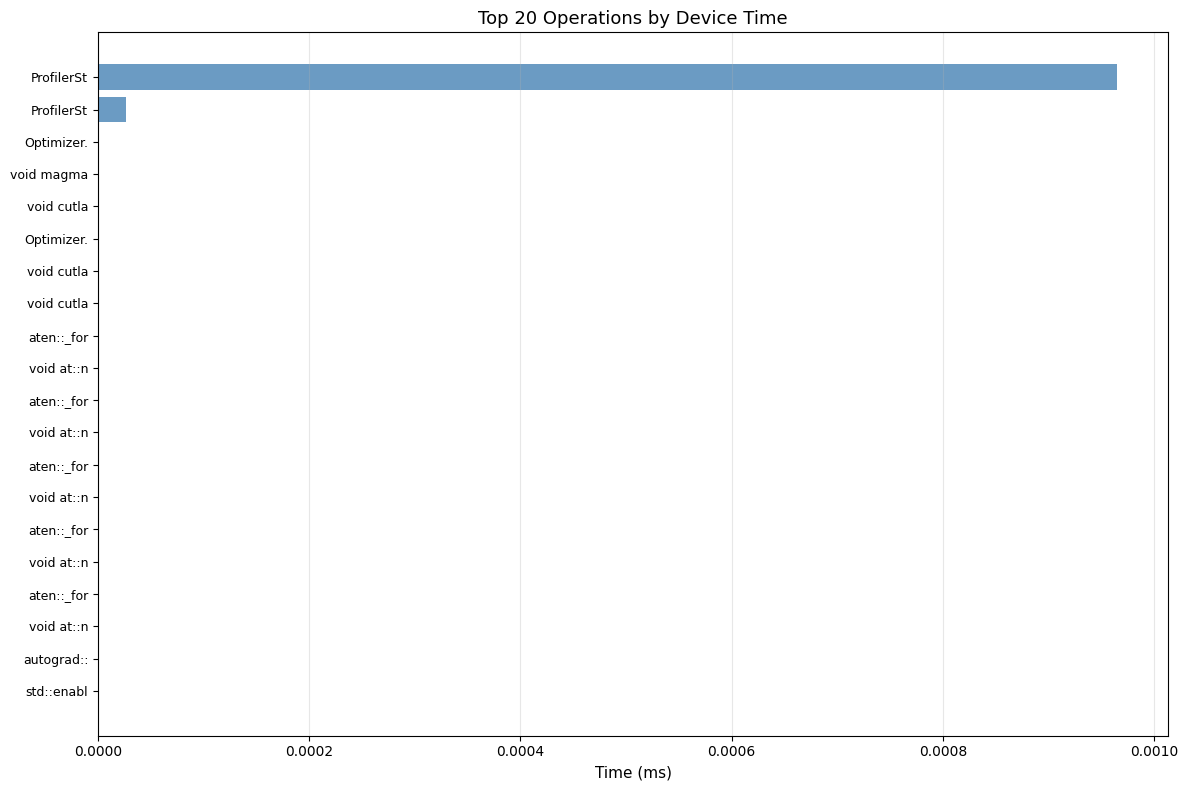

In [ ]:
def plot_profiler_top_k(csv_path, k=20, sort_by='self_cpu_time_total_us'):
    """
    Plot top-K functions from profiler summary CSV.
    
    Args:
        csv_path: Path to profiler summary CSV
        k: Number of top functions to display
        sort_by: Column to sort by ('self_cpu_time_total_us', 'self_cuda_time_total_us', etc.)
    """
    df = pl.read_csv(csv_path)
    
    # Filter out zero times and sort
    df_filtered = df.filter(pl.col(sort_by) > 0).sort(sort_by, descending=True).head(k)
    
    # Truncate names to at most 10 characters for readability
    df_filtered = df_filtered.with_columns(pl.col('name').str.slice(0, 10).alias('name'))
    
    # Convert microseconds to milliseconds for readability
    names = df_filtered['name'].to_list()
    times_ms = (df_filtered[sort_by] / 1000.0).to_numpy()
    
    # Create bar chart
    plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(names))
    plt.barh(y_pos, times_ms, align='center', alpha=0.8, color='steelblue')
    plt.yticks(y_pos, names, fontsize=9)
    plt.xlabel('Time (ms)', fontsize=11)
    plt.title(f'Top {k} Operations by {sort_by.replace("_", " ").title()}', fontsize=13)
    plt.gca().invert_yaxis()  # Highest at top
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot profiler results
profiler_csv = os.path.join(curr_dir, "profiler", "a2c_config", "a2c_config_summary.csv")

plot_profiler_top_k(profiler_csv, k=20, sort_by='cpu_time')